Download the data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-08-17 18:48:28--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.60, 13.224.29.19, 13.224.29.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2020-08-17 18:48:28 (46.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [63]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [64]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [65]:
print(category_lines['Italian'][:5])

['Garfagnini', 'Franco', 'Siena', 'Marino', "D'angelo"]


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [66]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [67]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [68]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)


In [69]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.LSTMCell(input_size + hidden_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hc = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hc)
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [70]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [71]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8214, -2.8802, -2.8535, -2.8953, -2.8889, -2.9072, -2.9209, -2.9025,
         -2.9031, -2.8765, -2.8730, -2.8635, -2.8771, -2.9373, -3.0021, -2.9264,
         -2.8866, -2.8257]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [72]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 0)


We will also want a quick way to get a training example (a name and its
language):




In [73]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Shamon
category = Polish / line = Kaminski
category = Italian / line = Sabbadin
category = Spanish / line = Ortega
category = Scottish / line = Mcintosh
category = Polish / line = Sokolowski
category = German / line = Oliver
category = Spanish / line = Oliver
category = French / line = Bertrand
category = Arabic / line = Guirguis


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [74]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [75]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def train_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def train_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [76]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        all_test_losses.append(test_loss.item() / n_test_instances)


5000 5% (0m 17s) 2.9621 Fay / Chinese ✗ (French)
10000 10% (0m 37s) 2.5764 Quach / Arabic ✗ (Vietnamese)
15000 15% (0m 56s) 3.0664 Victor / Russian ✗ (French)
20000 20% (1m 16s) 1.2496 Vu / Vietnamese ✓
25000 25% (1m 36s) 1.9699 Walentowicz / Spanish ✗ (Polish)
30000 30% (1m 56s) 1.0819 Oh  / Vietnamese ✗ (Korean)
35000 35% (2m 15s) 2.2254 Koumans / Japanese ✗ (Dutch)
40000 40% (2m 34s) 0.5391 Ferguson / Scottish ✓
45000 45% (2m 54s) 2.4040 Gallchobhar / Scottish ✗ (Irish)
50000 50% (3m 14s) 0.6484 You / Korean ✓
55000 55% (3m 34s) 1.9415 Kehoe / Irish ✗ (English)
60000 60% (3m 54s) 2.6256 Nonomura / Spanish ✗ (Japanese)
65000 65% (4m 13s) 2.5541 Pokorny / Dutch ✗ (Polish)
70000 70% (4m 33s) 1.8877 Sai / Chinese ✗ (Vietnamese)
75000 75% (4m 52s) 0.1310 Kaczka / Polish ✓
80000 80% (5m 12s) 1.6955 Stewart / English ✗ (Scottish)
85000 85% (5m 31s) 0.4474 Murray / Scottish ✓
90000 90% (5m 50s) 1.3918 Flaherty / Portuguese ✗ (English)
95000 95% (6m 9s) 1.0410 Espinoza / Spanish ✓
100000 100

In [77]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
gru_all_losses = []
gru_all_test_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        gru_all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        gru_all_test_losses.append(test_loss.item() / n_test_instances)

5000 5% (0m 41s) 2.7964 Grant / French ✗ (Scottish)
10000 10% (1m 30s) 2.8657 Vlach / Vietnamese ✗ (Czech)
15000 15% (2m 19s) 2.6903 Shaw / Chinese ✗ (Scottish)
20000 20% (3m 7s) 2.4864 Specht / French ✗ (Dutch)
25000 25% (3m 57s) 2.5658 Parkinson / Scottish ✗ (English)
30000 30% (4m 45s) 1.7098 Shadid / Arabic ✓
35000 35% (5m 34s) 3.5209 King / Chinese ✗ (Scottish)
40000 40% (6m 24s) 1.2805 Kaczka / Polish ✓
45000 45% (7m 15s) 4.4250 Tobias / Arabic ✗ (German)
50000 50% (8m 4s) 1.2525 Lin / Korean ✗ (Chinese)
55000 55% (8m 56s) 2.1737 Segher / German ✗ (Dutch)
60000 60% (9m 47s) 2.6703 Leandres / Portuguese ✗ (French)
65000 65% (10m 37s) 1.7711 Youn / Chinese ✗ (Korean)
70000 70% (11m 27s) 2.5081 Korycan / Irish ✗ (Czech)
75000 75% (12m 18s) 0.1482 Metrofanis / Greek ✓
80000 80% (13m 8s) 1.8174 Johnstone / English ✗ (Scottish)
85000 85% (13m 58s) 0.3118 Ponikarovsky / Russian ✓
90000 90% (14m 49s) 1.9608 Luscombe / French ✗ (English)
95000 95% (15m 40s) 1.2344 Morioka / Czech ✗ (Japan

In [78]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
lstm_all_losses = []
lstm_all_test_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    return output
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        lstm_all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                line_tensor = Variable(lineToTensor(line))
                output = evaluate(line_tensor)
                test_loss = test_loss + criterion(output, category_tensor)
        lstm_all_test_losses.append(test_loss.item() / n_test_instances)

5000 5% (0m 52s) 2.7312 Luc / Vietnamese ✓
10000 10% (1m 51s) 2.8193 Marshall / English ✗ (Scottish)
15000 15% (2m 49s) 3.0014 D'cruze / French ✗ (Portuguese)
20000 20% (3m 49s) 3.2566 Korycan / Irish ✗ (Czech)
25000 25% (4m 49s) 2.6929 O'Rourke / French ✗ (Irish)
30000 30% (5m 49s) 2.3874 Garcia / Japanese ✗ (Portuguese)
35000 35% (6m 49s) 1.6698 Janowski / Italian ✗ (Polish)
40000 40% (7m 50s) 2.8957 Serafim / English ✗ (Portuguese)
45000 45% (8m 50s) 1.5771 Lemaire / French ✓
50000 50% (9m 51s) 2.7778 Natale / French ✗ (Italian)
55000 55% (10m 51s) 1.4474 Riagan / Irish ✓
60000 60% (11m 52s) 1.1927 Wyrzyk / Polish ✓
65000 65% (12m 51s) 3.0300 Hay / Chinese ✗ (Scottish)
70000 70% (13m 51s) 0.3922 Fukuzawa / Japanese ✓
75000 75% (14m 50s) 1.4589 Sokolsky / Russian ✗ (Polish)
80000 80% (15m 51s) 1.7163 Ma / Korean ✗ (Vietnamese)
85000 85% (16m 52s) 0.1440 Jikov / Russian ✓
90000 90% (17m 52s) 0.1979 Katsourinis / Greek ✓
95000 95% (18m 51s) 0.9221 Chu / Vietnamese ✓
100000 100% (19m 51

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




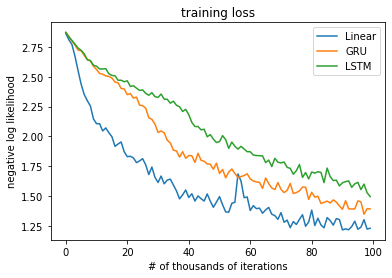

In [80]:
plt.figure()
plt.title('training loss')
plt.plot(all_losses, label='Linear')
plt.plot(gru_all_losses, label='GRU')
plt.plot(lstm_all_losses, label='LSTM')
plt.xlabel('# of thousands of iterations')
plt.ylabel('negative log likelihood')
plt.legend()
plt.show()

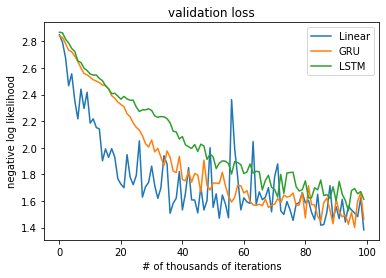

In [79]:
plt.figure()
plt.title('validation loss')
plt.plot(all_test_losses, label='Linear')
plt.plot(gru_all_test_losses, label='GRU')
plt.plot(lstm_all_test_losses, label='LSTM')
plt.xlabel('# of thousands of iterations')
plt.ylabel('negative log likelihood')
plt.legend()
plt.show()

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




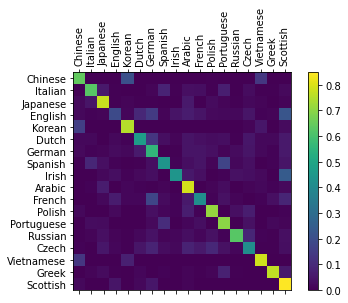

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.58) Russian
(-0.97) Czech
(-3.71) English

> Jackson
(-0.22) Scottish
(-2.10) English
(-3.07) Russian

> Satoshi
(-0.23) Arabic
(-1.94) Japanese
(-4.06) Italian
